In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Generate the data

according to:

x ~ N((0,0), [[1, -0.5],[-0.5, 1]]) when Y == 0

x ~ N((1,1+z), [[1,0],[0,1]]) when Y == 1

where Z has a Gaussian prior z ~ N(0,1)

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


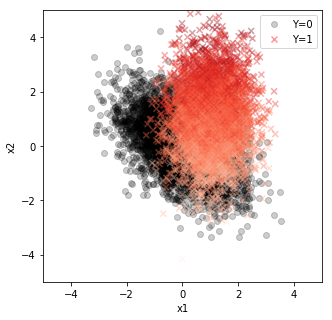

In [2]:
# generate variates
def generate(n_samples, z=None):
    Y = np.zeros(n_samples)
    Y[n_samples//2:] = 1

    if z == None:
        Z = np.random.normal(0, 1, size=n_samples)
    else:
        Z = z * np.ones(n_samples)

    X0 = np.random.multivariate_normal([0, 0], [[1, -0.5],[-0.5, 1]], size=n_samples//2)
    X1 = np.random.multivariate_normal([1, 1], 0.5*np.eye(2), size=n_samples//2)
    X1[:,1] += Z[n_samples//2:]
    X = np.concatenate([X0, X1])
    return X, Y, Z

def plot_variates(X, Y, Z):
    n_samples = X.shape[0]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(X[Y==0,0], X[Y==0,1], marker='o', color='k', alpha=0.2, label='Y=0')
    ax.scatter(X[Y==1,0], X[Y==1,1], marker='x', c=Z[n_samples//2:], alpha=0.4, cmap='Reds', label='Y=1')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    leg = ax.legend(loc='best')
    leg.legendHandles[1].set_color('red')
    fig.show()
    
n_samples = 10000
X, Y, Z = generate(n_samples)
plot_variates(X, Y, Z)

# Train a classifier without the adversary

Trains a classifier f(X) that gives p(f(X)) which depends on Z, i.e. p(f(X)|Z=z). 

In [13]:
def classifier(x_in, name):
    
    with tf.variable_scope(name):
        
        # define the output of the network
        dense1 = layers.relu(x_in, 20)
        dense2 = layers.relu(dense1, 20)
        output = layers.linear(dense2, 1)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
    
    return output, these_vars

def classifier_loss(clf_output, y_in):
    
    # define the loss and optimisation steps
    y_shaped = tf.reshape(y_in, shape=(n_samples, 1))
    loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_shaped, logits=clf_output))
    
    return loss_D

def train_classifier(x_in, y_in, generate, n_samples, n_epochs, name):
    
    # create the classifier graph (feed-forward)
    clf_output, vars_D = classifier(x_in, name)
    
    # create the loss function and the optimisation step
    loss_D = classifier_loss(clf_output, y_in)
    opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D)
    
    # train it
    losses = []
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        X, Y, Z = generate(n_samples)
        feed_dict = {x_in:X, y_in:Y}
        _, l_D, out = sess.run([opt_D, loss_D, clf_output], feed_dict=feed_dict)
        losses.append(l_D)
        
    # plot the losses
    fig, ax = plt.subplots()
    ax.plot(range(len(losses)), losses, c='k', label='loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.legend(loc='best')
    ax.set_title('Loss')
    plt.show()
    
    return clf_output, loss_D, vars_D

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

def plot_classifier_performance(x_in, y_in, clf_output, generate):
        
    # predict on special values of Z
    X, Y, Z = generate(n_samples)
    X1, Y1, Z1 = generate(n_samples, z=1)
    X0, Y0, Z0 = generate(n_samples, z=0)
    X_1, Y_1, Z_1 = generate(n_samples, z=-1)
    pred = sigmoid(sess.run(clf_output, feed_dict={x_in:X, y_in:Y}))
    pred1 = sigmoid(sess.run(clf_output, feed_dict={x_in:X1, y_in:Y1}))
    pred0 = sigmoid(sess.run(clf_output, feed_dict={x_in:X0, y_in:Y0}))
    pred_1 = sigmoid(sess.run(clf_output, feed_dict={x_in:X_1, y_in:Y_1}))
    
    # define figure (plot grid)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    lim = 3
    
    # plot the variates
    N = 300
    ax[0,0].scatter(X[Y==0,0], X[Y==0,1], marker='o', color='k', alpha=0.2, label='Y=0')
    ax[0,0].scatter(X1[Y1==1,0][:N], X1[Y1==1,1][:N], marker='x', c='darkred', alpha=1, label='Y=1, Z=1')
    ax[0,0].scatter(X0[Y0==1,0][:N], X0[Y0==1,1][:N], marker='x', c='red', alpha=1, label='Y=1, Z=0')
    ax[0,0].scatter(X_1[Y_1==1,0][:N], X_1[Y_1==1,1][:N], marker='x', c='tomato', alpha=1, label='Y=1, Z=-1')
    ax[0,0].set_ylim(-lim, lim)
    ax[0,0].set_xlim(-lim, lim)
    ax[0,0].set_xlabel('x1')
    ax[0,0].set_ylabel('x2')
    ax[0,0].set_title('Variates')
    leg = ax[0,0].legend(loc='best')

    # plot the ROC curves for Z={-1,0,1}
    fpr1, tpr1, _ = roc_curve(Y1[Z1==1], pred1[Z1==1])
    fpr0, tpr0, _ = roc_curve(Y0[Z0==0], pred0[Z0==0])
    fpr_1, tpr_1, _ = roc_curve(Y_1[Z_1==-1], pred_1[Z_1==-1])
    ax[1,0].plot(fpr1, tpr1, c='darkred', label='Z=1')
    ax[1,0].plot(fpr0, tpr0, c='red', label='Z=0')
    ax[1,0].plot(fpr_1, tpr_1, c='tomato', label='Z=-1')
    ax[1,0].legend(loc='best')
    ax[1,0].set_xlabel('False positive rate')
    ax[1,0].set_ylabel('True positive rate')
    ax[1,0].set_title('ROC curve')
    
    # plot the probability densities for Z=-1,0,1
    bins=30
    ax[1,1].hist(pred1, bins=bins, normed=True, color='darkred', histtype='step', label='Z=1')
    ax[1,1].hist(pred0, bins=bins, normed=True, color='red', histtype='step', label='Z=0')
    ax[1,1].hist(pred_1, bins=bins, normed=True, color='tomato', histtype='step', label='Z=-1')
    ax[1,1].set_xlabel('classifier output f(X|Z=z)')
    ax[1,1].set_ylabel('a.u.')
    ax[1,1].legend(loc='best')
    ax[1,1].set_title('Classifier output')
    
    # plot the decision boundary
    dec = ax[0,1].tricontourf(X[:,0], X[:,1], pred.ravel(), 20)
    ax[0,1].set_ylim(-lim, lim)
    ax[0,1].set_xlim(-lim, lim)
    ax[0,1].set_title('Decision boundary')
    ax[0,1].set_xlabel('x1')
    ax[0,1].set_ylabel('x2')
    plt.colorbar(dec, ax=ax[0,1])
    fig.show()
    plt.savefig('classifier.pdf')

Do the actual training

In [4]:
sess = tf.InteractiveSession()
ctr = 1

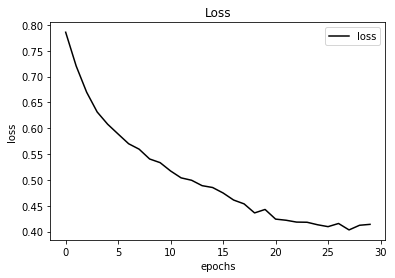

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


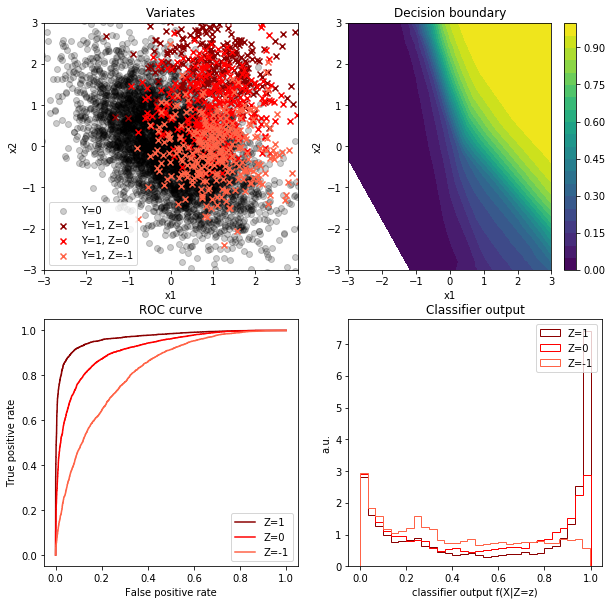

In [14]:
n_samples = 10000
n_epochs = 30
ctr+=1
name = 'name'+str(ctr)
    
# input placeholders
x_in = tf.placeholder(tf.float32, shape=[n_samples, 2], name='X1_X2')
y_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Y')

# train the classifier
clf_output, loss_D, vars_D = train_classifier(x_in, y_in, generate, n_samples, n_epochs, name)

# plot the performance of the classifier
plot_classifier_performance(x_in, y_in, clf_output, generate)

# Adversarial training

Train adversarially against different losses.

In [ ]:
def adversary_continuous(x_in, y_in, clf_output, n_components, name):
    
    with tf.variable_scope(name):
        
        # define the output of a network (depends on number of components)
        dense1 = layers.relu(clf_output, 20)
        dense2 = layers.relu(dense1, 20)
        output = layers.linear(dense2, 3*n_components)
        
        # build the pdf (max likelihood principle)
        mu = output[:, :n_components]
        sigma = output[:, n_components:2*n_components]
        pi = output[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          tf.math.exp(-(y_in - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                          tf.math.exp(-(y_in - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
        # make the loss and optimisation graphs
        nll = - tf.math.log(pdf)
        loss_R = tf.reduce_mean(nll)
        opt_R = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_R)
    
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
    
    return loss_R, opt_R, these_vars, nll

def plot_adversary(generate, n_samples, n_epochs, name):
    
    # make placeholders
    x_in = tf.placeholder(tf.float32, shape=[n_samples, 2], name='X1_X2')
    y_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Y')
    
    # create the classifier graphs
    output, loss_D, _, vars_D = classifier(x_in, y_in, name)
    
    # create the adversary graphs
    loss_R, _, vars_R, nll = adversary_continuous(x_in, y_in, output, 5, name+'_adv')
    
    # create the combined loss function
    lam = 1
    loss_DR = loss_D + lam*loss_R
    
    # create the optimisers
    opt_R = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_R, var_list=vars_R)
    opt_DR = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_DR, var_list=vars_D)
    
    # initialise variables
    sess.run(tf.global_variables_initializer())
    
    losses = {'lR':[], 'lD':[], 'lDR':[]}
    #for epoch in range(n_epochs):
    for epoch in range(1):
        
        # train the adversary
        temp_loss_R = []
        for sub_epoch in range(100):
            X, Y, Z = generate(n_samples)
            feed_dict = {x_in:X, y_in:Y}
            _, l_R, NLL = sess.run([opt_R, loss_R, nll], feed_dict=feed_dict)
            print(NLL[:20])
            print(l_R)
            temp_loss_R.append(l_R)
        
        print(temp_loss_R)
        fig, ax = plt.subplots()
        ax.plot(range(len(temp_loss_R)), temp_loss_R)
        plt.show()
        
    #    X, Y, Z = generate(n_samples)
    #    feed_dict = {x_in:X, y_in:Y}
    #    _, l, out = sess.run([opt, loss, output], feed_dict=feed_dict)
    #    losses.append(l)
    

plot_adversary(generate, n_samples, 30, 'name18')